In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score,f1_score


In [ ]:
import pandas as pd
# cleaned data is posted on drive demo to pull 
url = 'https://drive.google.com/file/d/1zA-C6m7Rv9y051iVr8voieRRm-CnnzA1/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.head()

,unique_fire_identifier,lattitude,longitude,acres_burned,fire_cause,incident_name,IsFSAssisted,origin_county,state,year,...,area (acres),population,d0,d1,d2,d3,d4,DSCI_avg,DSCI_summed,precipitation(in)
0,2003-WYCMX-200237,-105.563067,44.603340,139.091837,Unknown,SCHWARTZ,1.0,Campbell,WY,2003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-CABDU-006784,-117.076679,34.733894,1906.698008,Unknown,MENTONE,1.0,San Bernardino,CA,2004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-IDGBK-000002,-116.216680,43.666673,685.728842,Unknown,NIFC RAMP SUPPORT,1.0,Ada,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-IDCTF-008902,-111.426912,42.096336,20.000000,Unknown,St. Charles RX,0.0,Bear Lake,ID,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-AZPNF-000975,-112.072414,34.598306,77.946287,Unknown,Mingus/Cherry Rx,0.0,Yavapai,AZ,2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.isnull().sum().sum()

448363

In [ ]:
df_clean = df.fillna(0)

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = df_clean.copy().select_dtypes(include=numerics)
catdf = df_clean.copy().select_dtypes(include=categorical)
catdf.drop(columns=['unique_fire_identifier','incident_name'],inplace=True)
catdf.head()

,fire_cause,origin_county,state
0,Unknown,Campbell,WY
1,Unknown,San Bernardino,CA
2,Unknown,Ada,ID
3,Unknown,Bear Lake,ID
4,Unknown,Yavapai,AZ


In [ ]:
# will dummify these features to obtain correlations  
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(213787, 1512)


,lattitude,longitude,acres_burned,IsFSAssisted,year,month,value,anomaly,area (acres),population,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-105.563067,44.603340,139.091837,1.0,2003,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,-117.076679,34.733894,1906.698008,1.0,2004,7,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-116.216680,43.666673,685.728842,1.0,2008,7,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-111.426912,42.096336,20.000000,0.0,2008,9,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-112.072414,34.598306,77.946287,0.0,2008,10,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
fire_class = []
for obs in df['acres_burned']:
    if 0<=obs <= 0.26:
        fire_class.append(0)
    elif 0.26 <= obs <10.0:
        fire_class.append(1)
    elif 10.0<=obs<100.0:
        fire_class.append(2)
    elif 100.0<=obs<300:
        fire_class.append(3)
    elif 300.0 <= obs <1_000:
        fire_class.append(4)
    elif 1_000.0<=obs<5_000.0:
        fire_class.append(5)
    elif 5_000.0 <= obs <10_000:
        fire_class.append(6)
    elif 10_000.0 <=obs<50_000:
        fire_class.append(7)
    elif 50_000.0<=obs<100_000:
        fire_class.append(8)
    elif 100_000.0<=obs<500_000.0:
        fire_class.append(9)
    elif 500_000.0 <= obs <1_000_000:
        fire_class.append(9)
    elif obs >= 1_000_000.0:
        fire_class.append(9)
    else:
        print(obs)
dummified_1['fire_class'] = fire_class 


In [ ]:
dummified_1['fire_class'].value_counts(normalize=False)

0    68627
1    48909
2    31448
4    22336
5    22086
3    18613
7      804
6      688
8      155
9      121
Name: fire_class, dtype: int64

In [ ]:
model_1 = dummified_1.drop(columns='acres_burned')
model_1 = model_1.sort_values(by=['year','month'])

In [ ]:
X =model_1.drop(columns = 'fire_class') 
y= model_1['fire_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,shuffle=True)


y_test.unique()

array([0, 4, 5, 2, 1, 7, 3, 6, 9, 8])

In [ ]:
# xgboost for feature importance on a classification problem
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot

In [ ]:
model = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=10,learning_rate=0.1,booster='gbtree',reg_alpha=0,max_delta_step=0)
model.fit(X_train, y_train)

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = model.predict(X_test)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)


Accuracy: 56.01%


,0,1,2,3,4,5,6,7,8,9
0,13303,2190,368,92,724,480,0,0,0,0
1,6540,3941,875,133,546,192,0,0,0,0
2,2199,1580,3435,134,466,48,0,0,0,0
3,1150,828,677,1496,479,23,0,0,0,0
4,889,581,466,87,3481,80,0,0,0,0
5,466,330,232,52,162,4279,1,0,0,0
6,107,31,7,3,15,9,0,0,0,0
7,143,26,9,1,8,14,0,0,0,0
8,32,1,0,0,2,4,0,0,0,0
9,19,3,0,0,4,4,0,0,0,0


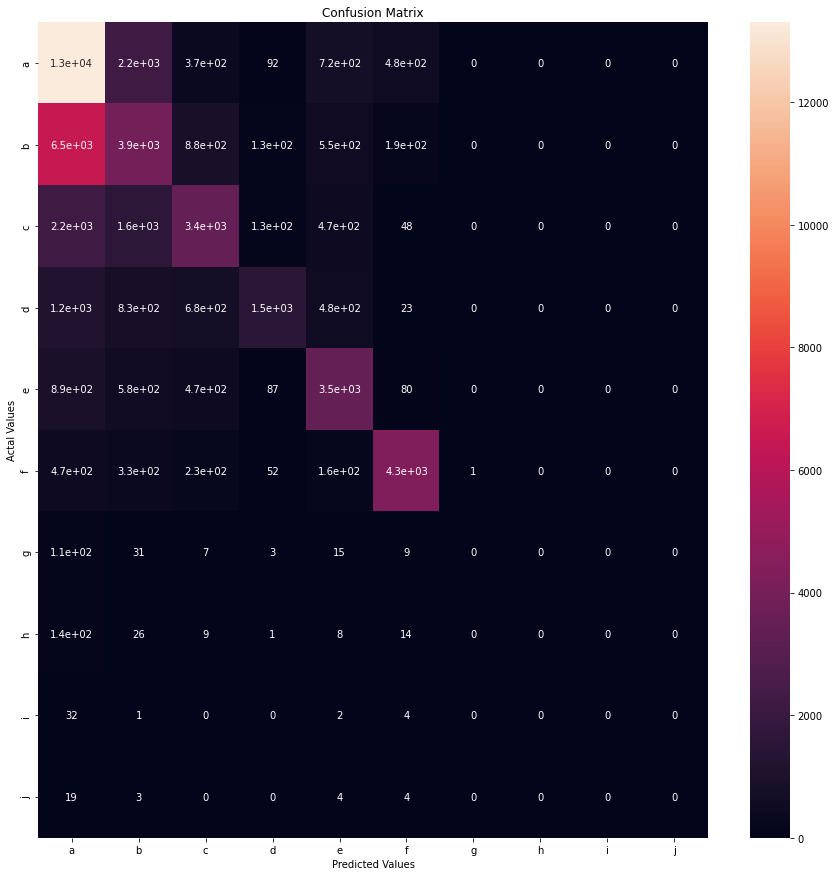

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance);
pyplot.show()

In [ ]:
# Average is assigned micro
#
precisionScore_sklearn_microavg = precision_score(y_test, y_pred, average='micro', zero_division=0)
#
# Average is assigned macro
#
precisionScore_sklearn_macroavg = precision_score(y_test, y_pred, average='macro')
#
f1_score_sklearn_macro = f1_score(y_test, y_pred, average='macro')
f1_score_sklearn_micro = f1_score(y_test, y_pred, average='micro')

# Printing micro and macro average precision score
#
print(precisionScore_sklearn_microavg, precisionScore_sklearn_macroavg)
f1_score_sklearn_micro,f1_score_sklearn_macro

0.5600875633805452 0.3689405679711625


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.5600875633805452, 0.33491063826457895)

In [ ]:
xgboost2 = XGBClassifier(objective='multi:softmax',seed=42,n_estimators=200,learning_rate=0.1,booster='gbtree',reg_alpha=0)
xgboost2.fit(X_train, y_train)

XGBClassifier(n_estimators=200, objective='multi:softprob', seed=42)

In [ ]:
# make predictions for test data
y_pred = xgboost2.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
preds = xgboost2.predict(X_test)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)
pd.DataFrame(cm)

Accuracy: 61.37%


,0,1,2,3,4,5,6,7,8,9
0,14284,1952,334,97,244,246,0,0,0,0
1,6413,4582,681,197,212,126,0,16,0,0
2,1972,1888,3577,258,124,34,0,9,0,0
3,881,890,363,2276,206,33,0,3,1,0
4,856,656,184,199,3631,54,0,4,0,0
5,457,319,59,112,124,4436,0,15,0,0
6,101,47,3,5,11,2,0,3,0,0
7,129,31,9,5,6,6,0,14,1,0
8,26,7,0,0,1,3,0,2,0,0
9,20,2,1,0,1,5,0,0,0,1


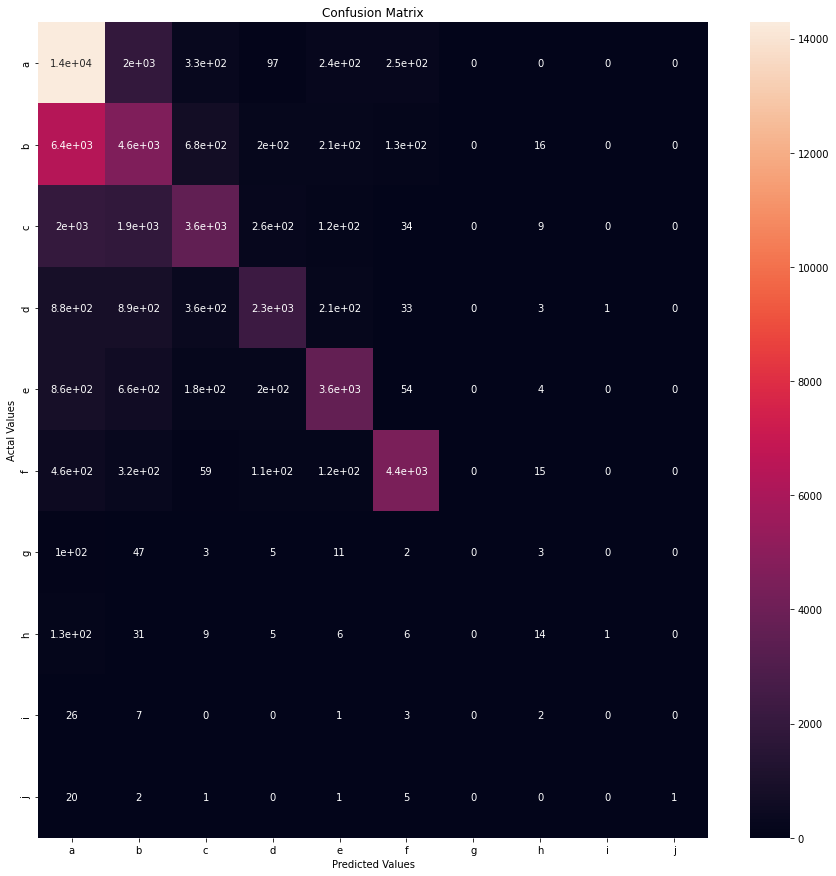

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['a','b','c','d','e','f','g','h','i','j'], 
                     columns = ['a','b','c','d','e','f','g','h','i','j'])

#Plotting the confusion matrix
plt.figure(figsize=(15,15))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()